### Exercise Sheet 2

#### 2.1 ODE with time dependent Parameter
Use TorchPhysics to solve the ODE for falling with a parachute:
\begin{align*}
    \partial_t^2 u(t) &= D(t)(\partial_t u(t))^2 - g \\
    u(0) &= H \\
    \partial_t u(0) &= 0
\end{align*}
Where now $D: \R \to \R$ with $ D(t) = 2.0\cdot(1.0 + \sin(4\cdot t))$.

In [1]:
#!pip install torchphysics

In [2]:
import torch
import torchphysics as tp
import pytorch_lightning as pl

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0

### TODO: implement the function of D.
def D(t):
    return 2.0 * (1.0 + torch.sin(4*t))
g, H = 9.81, 50.0

# number of time points 
N_t = 500
N_initial = 1

train_iterations = 10000
learning_rate = 1.e-3

In [3]:
### Spaces, Domains and Sampler like yesterday:
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
 
int_t = tp.domains.Interval(T, t_min, t_max)

ode_sampler = tp.samplers.RandomUniformSampler(int_t, n_points=N_t)
initial_sampler = tp.samplers.RandomUniformSampler(int_t.boundary_left, n_points=N_initial)

In [4]:
### TODO: Create the neural network with 3 hidden layers and 25 neurons each.
model = tp.models.FCN(T, U, hidden=(25, 25, 25))

In [5]:
### TODO: Define condition for the ODE:
def ode_residual(u, t):
    u_t = tp.utils.grad(u, t)
    u_tt = tp.utils.grad(u_t, t)
    return u_tt - D(t)*u_t**2 + g

ode_condition = tp.conditions.PINNCondition(model, ode_sampler, ode_residual)

In [6]:
### Other conditions are also like before:
def position_residual(u):
    return u - H

initial_position_condition = tp.conditions.PINNCondition(model, initial_sampler, position_residual)

In [7]:
def velocity_residual(u, t):
    return tp.utils.grad(u, t)

initial_velocity_condition = tp.conditions.PINNCondition(model, initial_sampler, velocity_residual)

In [8]:
### Syntax for the training is already implemented:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate) 
solver = tp.solver.Solver([ode_condition, initial_position_condition, initial_velocity_condition],
                          optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=train_iterations, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 901   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
901       Trainable params
0         Non-trainable params
901       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

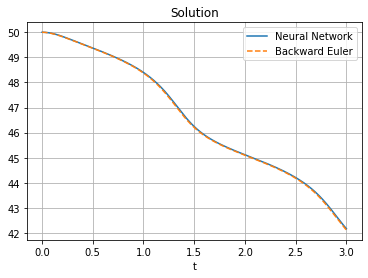

In [18]:
### Here, plot the solution:
import matplotlib.pyplot as plt

plot_sampler = tp.samplers.PlotSampler(int_t, 200)
fig = tp.utils.plot(model, lambda u: u, plot_sampler)
plt.title("Solution")

# Solution for comparision with backward euler:
t = torch.linspace(t_min, t_max, 200)
dt = t[1] - t[0]
D_fn = D(t)
u, v = torch.zeros_like(t), torch.zeros_like(t)
u[0] = H
for i in range(len(t)-1):
    v[i+1] = 1/(2*dt*D_fn[i+1]) - torch.sqrt(1/(2*dt*D_fn[i+1])**2 - (v[i] - dt*g)/(dt*D_fn[i+1]))
    u[i+1] = u[i] + dt * v[i+1]

plt.plot(t, u, linestyle="--")
plt.legend(["Neural Network", "Backward Euler"])